# Bert-base-multilingual-uncased

In [1]:
#!pip install ktrain

In [2]:
#!pip install sentence_transformers

First we import the necessary libraries and load the csv

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

#from sentence_transformers import SentenceTransformer

data_set = pd.read_csv(r"C:\Users\volpe\Documents\MARCO\0.master\0.Corsi\Machine_learning\Carman_google_drive\TextMining\data_0905_semicolon.csv",sep=";")

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_set.head()

,Unnamed: 0,Ticker,Titles,Date,Var_prc,Target
0,0,MMM,<title>Here is What to Know Beyond Why 3M Comp...,0,0.008478,0.0
1,69,MMM,<title>What's Next For 3M Stock After A 15% Fa...,0,0.008478,0.0
2,68,MMM,<title>MMM Stock Quote Price and Forecast - CN...,0,0.008478,0.0
3,67,MMM,<title>3M Announces Upcoming Investor Event - ...,0,0.008478,0.0
4,66,MMM,<title>Open Door: Claire Pentecost + Beth Jaco...,0,0.008478,0.0


In [5]:
# we want a input dataframe where there is only a row for each ticker, 10 columns with the 10 titles, and the target
col =["Ticker"] + [ "Article " + str(i+1)  for i in range(10)] + ["Target"]
input_df = pd.DataFrame(columns=col)

for ticker in data_set["Ticker"].unique():
    #extract the rows corresponfing to the ticker
    ticker_df = data_set[ data_set["Ticker"] ==  ticker ]
    #create the new row to append to the dataset
    articles_list = ticker_df["Titles"].to_list()
    ticker_target = ticker_df["Target"].iloc[0]
    new_row = [ticker] + articles_list + [ticker_target] 
    #append the new row to the dataset
    input_df = input_df.append(pd.Series(new_row, index=col),ignore_index=True)
input_df = input_df.dropna()
print(input_df.shape)
input_df.iloc[60:63,:]

(498, 12)


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target
60,BAX,<title>Biden is tweaking an asylum rule to spe...,<title>Baxter's (BAX) Latest FDA Approval to B...,<title>Mayor Sarno Joined with Bax and Nagle t...,"<title>Based On Its ROE, Is Baxter Internation...",<title>(01/02/24) Top Picks 2024: Baxter Inter...,"<title>Baxter (BAX) Beats on Q3 Earnings, Dive...",<title>Is Baxter International (BAX) Too Good ...,<title>Baxter International Inc.'s (NYSE:BAX) ...,<title>Author Correction: Bax Inhibitor-1 regu...,<title>Estimating The Fair Value Of Baxter Int...,-1.0
61,BDX,"<title>When the Price of (BDX) Talks, People L...","<title>Becton, Dickinson and Company (NYSE:BDX...",<title>Beyond the Balance Sheet: What SWOT Rev...,<title>Becton Dickinson (BDX) Surpasses Q3 Ear...,<title>Breaking: BDx Indonesia to acquire Indo...,<title>BD Increases Access to Cutting-Edge Ima...,<title>Investors Still Waiting For A Pull Back...,<title>BDx acquires data center freehold in Si...,<title>BDX Droids Coming to Star Wars Galaxy's...,<title>Why Becton Dickinson (BDX) is a Top Val...,-1.0
63,BBY,<title>Best Buy (NYSE:BBY) PT Lowered to $67.0...,<title>Best Buy (BBY) Up 11.1% Since Last Earn...,<title>Best Buy Reports Q4 FY24 Results - Best...,<title>Decoding Best Buy Co Inc (BBY): A Strat...,<title>Should You Think About Buying Best Buy ...,<title>This Insider Has Just Sold Shares In Be...,<title>Best Buy Geek Squad employees report ma...,<title>Best Buy Recalls Insignia® Air Fryers a...,"<title>Down 15% This Year, Where Is Best Buy S...",<title>Dividend Investors: Don't Be Too Quick ...,0.0


Now we want to train the multilingual-bert model, as it requires a string as input we need to concatenate the titles

In [6]:
# Cleaning the columns and creating the input for the multilingual bert
for i in range(1, 11):
    column_name = f'Article {i}'
    input_df[column_name] = input_df[column_name].str.replace('<title>', '').str.replace('</title>', '')

input_df["Concatenated Titles"] = input_df.iloc[:, 1:11].apply(lambda row: ' '.join(row), axis=1)
input_df.dropna(axis = 0)
# Print the resulting DataFrame
input_df.iloc[50:53,:]

,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
50,ADP,Ep. 539 - Analyzing the New Post-Draft Startup...,ADP Increases Cash Dividend; Marks 49th Consec...,Why Is Software Megacap ADP's Stock Trading Hi...,The Biggest ADP Fallers: How long Gerrit Cole ...,ADP Ventures | Creating a better world of work...,"Private payrolls rose by 140,000 in February, ...",ADP Reimagines the Human Capital Management Cl...,ADP: Employers Added 103000 Workers in Novembe...,ADP Declares Regular Quarterly Dividend - PR N...,ADP vs Paychex: Which Payroll Software is Bett...,0.0,Ep. 539 - Analyzing the New Post-Draft Startup...
51,AZO,(AZO) Investment Report - Stock Traders Daily,Light-tuned selective photosynthesis of azo- a...,Optimal of black anti-static AZO/Al2O3-SiO2-Vx...,"New azo-azomethine derivatives: Synthesis, cha...",NLO azo compounds with sulfonamide groups: A t...,Self-organized patterning on azo molecular gla...,"Synthesis, spectroscopic characterization and ...",Protocol for photoelectrocatalytic synthesis o...,Easily accessible and tunable porous organic p...,"Reversal in solvatochromism, photochromism and...",0.0,(AZO) Investment Report - Stock Traders Daily ...
52,AVB,Decoding AvalonBay Communities Inc (AVB): A St...,'Massive arguments' - AVB reveals Tottenham re...,Van der Vaart calls AVB 'an idiot' and explain...,10 Ways to Use AVB ('Already Vaped Bud') Marij...,Ruben Amorim to Liverpool: Will he become a Mo...,AVIATION LOGISTICS SUPPORT IN THE INDO-PACIFIC...,6 Easy Ways for Getting High Again with Your A...,‘This is really uncomfortable’ – John Terry an...,InfoComm 2023: DiGiCo Introduces Milan-Certifi...,Analysts See Upside On These 3 REITs - AvalonB...,0.0,Decoding AvalonBay Communities Inc (AVB): A St...


Divide train and test set \
            VALIDATION ???

In [7]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)

In [8]:
model_name = 'bert-base-multilingual-uncased'
transformer = text.Transformer(model_name, maxlen=500, class_names= np.array([0,1,2]))
y_train = y_train + 1          # classes need to start from
y_test = y_test + 1

In [9]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_test = transformer.preprocess_test(list(x_test["Concatenated Titles"]), list(y_test["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 137
	95percentile : 160
	99percentile : 174


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\utils.py:769: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  "class_names implies classification but targets array contains float(s) instead of integers or strings"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 137
	95percentile : 164
	99percentile : 169


In [10]:
model = transformer.get_classifier()
batch_size = 5                        #small training dataset
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=batch_size)

In [11]:
print(processed_train.y)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


simulating training for different learning rates... this may take a few moments...
79/79 [==============================] - 888s 11s/step - loss: 27.6450 - accuracy: 0.4632


done.
Visually inspect loss plot and select learning rate associated with falling loss


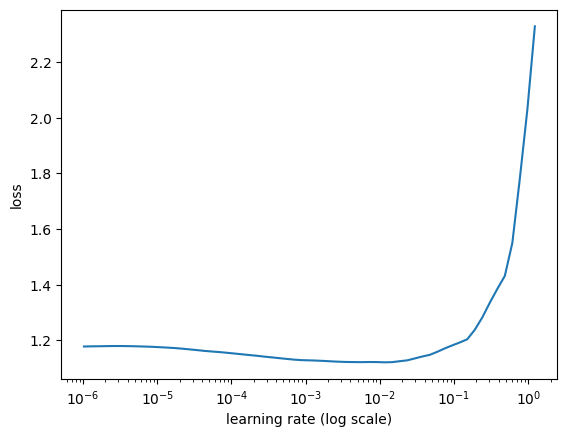

In [12]:
learner.lr_find(show_plot=True,  max_epochs=1)

In [13]:
learner.fit_onecycle(1e-3, 2)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/2
80/80 [==============================] - 1035s 13s/step - loss: 0.9487 - accuracy: 0.6583 - val_loss: 1.5105 - val_accuracy: 0.5900
Epoch 2/2
80/80 [==============================] - 1058s 13s/step - loss: 0.9086 - accuracy: 0.6910 - val_loss: 0.9793 - val_accuracy: 0.5900


In [14]:
learner.validate(class_names=transformer.get_classes())

4/4 [==============================] - 40s 8s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.59      1.00      0.74        59
           2       0.00      0.00      0.00        18

    accuracy                           0.59       100
   macro avg       0.20      0.33      0.25       100
weighted avg       0.35      0.59      0.44       100



c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 23,  0],
       [ 0, 59,  0],
       [ 0, 18,  0]], dtype=int64)

In [15]:
'''
# let's see some predictions
'''
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
import random as rand
i = rand.randint(0,100)

print(input_df["Ticker"].iloc[i],"\n",\
      "Prediction: \n",\
      predictor.predict(x_test["Concatenated Titles"].iloc[i]),\
      "\nTarget: \n",\
      y_train["Target"].iloc[i])

CCL 
 Prediction: 
 1 
Target: 
 0.0


It always predicts class 1... not really good

### Let's try embedding + NN

In [16]:
from sentence_transformers import SentenceTransformer

In [17]:
m = SentenceTransformer("bert-base-multilingual-uncased")

No sentence-transformers model found with name C:\Users\volpe/.cache\torch\sentence_transformers\bert-base-multilingual-uncased. Creating a new one with MEAN pooling.


In [18]:
c = len(m.encode("I love transformers!"))                   # dim embedding
r = input_df.shape[0]    # dim dataset  

X = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(input_df.iloc[idx,:].loc["Concatenated Titles"])
  X[idx,:] = sentence_embeddings

In [19]:
input_df.iloc[497,:].loc["Concatenated Titles"]

"Smoothie King names Yum Brands veteran Gavin Felder chief financial officer - Nation's Restaurant News Yum China Holdings, Inc. (NYSE:YUMC) Q1 2024 Earnings Call Transcript - Yahoo Finance Yum Brands Doubles Tech Spending, Expands Generative AI Use - PYMNTS.com Compared to Estimates, Yum China (YUMC) Q1 Earnings: A Look at Key Metrics - Yahoo Finance Yum! Brands, Inc. (NYSE:YUM) Q4 2023 Earnings Call Transcript - Yahoo Finance Yum China (YUMC) Q4 2023 Earnings Call Transcript - The Motley Fool Yum Brands (YUM) Reports Next Week: Wall Street Expects Earnings Growth - Yahoo Finance Pizza Hut Announces Carl Loredo President of Pizza Hut U.S. - Business Wire Yum China (NYSE:YUMC) Misses Q1 Sales Targets - Yahoo Finance Yum! Brands (YUM) Reports Earnings Tomorrow: What To Expect - Yahoo Finance"

In [20]:
t_size = 0.2

x_train, x_test, y_train, y_test = train_test_split( X, np.array(input_df["Target"]), test_size=t_size, random_state=42)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop, SGD, Adagrad

We prepare the data for a classification with neural networks

In [22]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train[i])  
    y_train_dummy[i, class_idx] = 1


y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_test_dummy[i,round(y_test[i])] = 1

And train a neural network

In [23]:
model=Sequential()
model.add(Dense(units=c, activation='relu', input_dim=c))
model.add(Dense(units=900, activation='tanh'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=200,batch_size=6)  


pred_train=model.predict(x_train)
pred_test=model.predict(x_test)

Epoch 1/200


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


67/67 [==============================] - 1s 5ms/step - loss: 0.2991
Epoch 2/200
67/67 [==============================] - 0s 5ms/step - loss: 0.2940
Epoch 3/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 4/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 5/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 6/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 7/200
67/67 [==============================] - 0s 5ms/step - loss: 0.2940
Epoch 8/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 9/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 10/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 11/200
67/67 [==============================] - 0s 6ms/step - loss: 0.2940
Epoch 12/200
67/67 [==============================] - 1s 10ms/step - loss: 0.2940
Epoch 13/200
67/67 [============================

Now we evaluate the model on the validation set

In [24]:
pred_test_2 = np.zeros(pred_test.shape)
for i in range(len(pred_test)):
  pred_test_2[i, pred_test[i,:].argmax()  ] = 1

pred_train_2 = np.zeros(pred_train.shape)
for i in range(len(pred_train)):
  pred_train_2[i, pred_train[i,:].argmax()  ] = 1

In [25]:
#print(pred_train.shape,"--",x_train.shape)
#print(pred_test.shape,"--",x_test.shape)

print(pred_train[23,:],"--",y_train_dummy[0,:])
print(  )
print("Prediction","--","  Target")
for i in range(180,200):
  print(pred_train_2[i,:],"--",y_train_dummy[i,:])

[1.2470087e-10 2.2486243e-10 3.0789777e-11] -- [1. 0. 0.]

Prediction --   Target
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [0. 0. 1.]
[0. 1. 0.] -- [0. 1. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [0. 0. 1.]
[0. 1. 0.] -- [0. 0. 1.]
[0. 1. 0.] -- [0. 0. 1.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [0. 0. 1.]
[0. 1. 0.] -- [0. 0. 1.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 1. 0.] -- [1. 0. 0.]


In [26]:
MSE_train = np.sum(  (pred_train-y_train_dummy)**2)   /pred_train.shape[0]
MSE_test = np.sum(  (pred_test-y_test_dummy)**2)   /pred_test.shape[0]

print("MSE_train: ",MSE_train)
print("MSE_test: ",MSE_test)


MSE_train = np.sum(  (pred_train_2-y_train_dummy)**2)   /pred_train.shape[0]
MSE_test = np.sum(  (pred_test_2-y_test_dummy)**2)   /pred_test.shape[0]

print("MSE_train: ",MSE_train)
print("MSE_test: ",MSE_test)

MSE_train:  0.9999999997212882
MSE_test:  0.9999999997196511
MSE_train:  1.7537688442211055
MSE_test:  1.64


In [27]:
miss_train = np.sum(  abs(pred_train_2-y_train_dummy)/2)   /pred_train.shape[0]
miss_test = np.sum(  abs(pred_test_2-y_test_dummy)/2)   /pred_test.shape[0]

print("Missclasification_train: ",miss_train)
print("Missclassification_test: ",miss_test)

Missclasification_train:  0.8768844221105527
Missclassification_test:  0.82
